In [1]:
# Charger autoreload
%load_ext autoreload
%autoreload 2

# Imports standards
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers
from scipy.stats import norm
import pandas as pd

# === IMPORTANT ===
# Charger tes fichiers .py depuis ton dataset privé
import sys
sys.path.append("/kaggle/input/datasets-private") #no originale de GLOIRE_SAMBA_VAES

from utils import sample_batch, display        # anciennement notebooks.utils
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

2025-11-15 22:47:59.497685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763246879.520176      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763246879.527205      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Définition du chemin CelebA
data_dir = "/kaggle/input/celeba-dataset"

# Paramètres du projet

In [3]:

IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

# Préparation des données

In [4]:
# Chargement du dataset CelebA
train_data = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

Found 202599 files.


I0000 00:00:1763247310.659422      88 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
# Prétraitement des données
def preprocess(img):
    """
    Normalise une image en convertissant ses valeurs en flottant et les mettant à l'échelle entre 0 et 1.

    Args:
        img (tf.Tensor): L'image à prétraiter.

    Returns:
        img (tf.Tensor): L'image normalisée.
    """
    # Conversion des valeurs de l'image en flottant et mise à l'échelle entre 0 et 1
    img = tf.cast(img, "float32") / 255.0
    return img

# Application de la fonction de prétraitement aux données d'entraînement
train = train_data.map(lambda x: preprocess(x))

In [6]:
# Échantillonne un lot de données à partir de l'ensemble de données d'entraînement
train_sample = sample_batch(train)

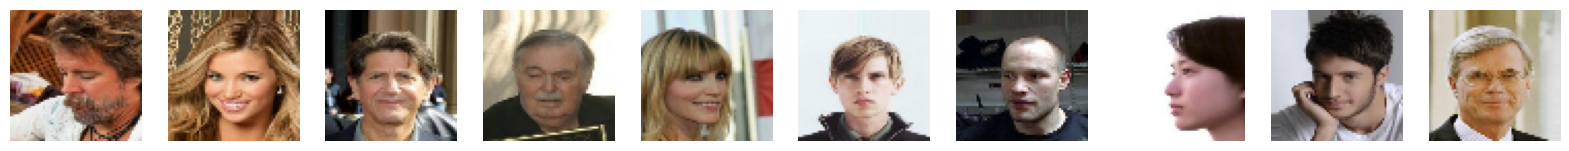

In [7]:
# Affiche quelques visages de l'ensemble d'entraînement
display(train_sample, cmap=None)

# Construction du Variational Autoencoder

In [8]:
# Classe de couche personnalisée pour l'échantillonnage dans le VAE
class Sampling(layers.Layer):
    def call(self, inputs):
        """
        Effectue l'échantillonnage pour générer des échantillons à partir des moyennes et des log-variances latentes.

        Args:
            inputs (tuple): Un tuple contenant les tenseurs z_mean et z_log_var.

        Returns:
            z (tf.Tensor): Le tenseur résultant de l'échantillonnage.
        """
        # Extraction des moyennes et des log-variances
        z_mean, z_log_var = inputs

        # Obtention de la taille du lot (batch) et de la dimension latente
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Génération d'un échantillon epsilon à partir d'une distribution normale
        epsilon = K.random_normal(shape=(batch, dim))

        # Calcul de l'échantillon z en utilisant les moyennes, les log-variances et epsilon
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        return z

In [9]:
# Définition de l'entrée du modèle d'encodage
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Construction des couches de convolution et de normalisation
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Ajout de couches de convolution, de normalisation et de ReLU supplémentaires
# Cela permet d'apprendre des caractéristiques à différentes échelles
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# ➤ ICI : on capture la forme
shape_before_flattening = x.shape[1:]

x = layers.Flatten()(x)

# Projection des activations dans l'espace latent (z_mean et z_log_var)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

# Utilisation de la classe personnalisée Sampling pour l'échantillonnage
z = Sampling()([z_mean, z_log_var])

# Création du modèle d'encodage
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Affichage du résumé du modèle d'encodage
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ encoder_input[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    205,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    205,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 523,600 (2.00 MB)

 Trainable params: 523,088 (2.00 MB)

 Non-trainable params: 512 (2.00 KB)

In [10]:
# Décodeur
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Reshape(shape_before_flattening)(x)

# 1
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# 2
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# 3
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# 4
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Couche de sortie (pas de stride=2 ici)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       205,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,387 (1.37 MB)

 Trainable params: 357,827 (1.37 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [11]:
# Classe VAE (Variational Autoencoder)
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        Initialise un modèle Variational Autoencoder (VAE).

        Args:
            encoder (tf.keras.models.Model): Le modèle de l'encodeur.
            decoder (tf.keras.models.Model): Le modèle du décodeur.
            **kwargs: Arguments supplémentaires pour la classe parente.
        """
        super(VAE, self).__init__(**kwargs)
        
        # Initialisation de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder
        
        # Création de traqueurs pour les métriques
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Métriques à surveiller pendant l'entraînement.

        Returns:
            list: Liste de métriques à surveiller.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """
        Appelle le modèle sur une entrée particulière.

        Args:
            inputs: Les données d'entrée.

        Returns:
            tuple: Un tuple contenant les moyennes latentes, les log-variances latentes et les reconstructions.
        """
        # Appel de l'encodeur et du décodeur
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """
        Étape exécutée lors de l'entraînement.

        Args:
            data: Les données d'entraînement.

        Returns:
            dict: Un dictionnaire contenant les métriques de perte.
        """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            
            # Calcul de la perte de reconstruction
            reconstruction_loss = BETA * tf.reduce_mean(tf.square(data - reconstruction))
            
            # Calcul de la perte de divergence de Kullback-Leibler (KL)
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            
            # Calcul de la perte totale
            total_loss = reconstruction_loss + kl_loss

        # Calcul des gradients et mise à jour des poids
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Mise à jour des métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """
        Étape exécutée lors de la validation.

        Args:
            data: Les données de validation.

        Returns:
            dict: Un dictionnaire contenant les métriques de perte.
        """
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        
        # Calcul de la perte de reconstruction
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        
        # Calcul de la perte de divergence de Kullback-Leibler (KL)
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        
        # Calcul de la perte totale
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [12]:
# Créer un Variational Autoencoder (VAE)
vae = VAE(encoder, decoder)

# Entrainer le modèle

In [13]:
# Compiler le Variational Autoencoder (VAE)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [14]:
# Créer un point de contrôle pour sauvegarder le modèle
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/best_model.keras",  # Chemin pour sauvegarder les poids et le modèle complet
    save_weights_only=False,  # Sauvegarder le modèle complet, pas seulement les poids
    save_freq="epoch",  # Sauvegarder à chaque fin d'époque
    monitor="loss",  # Surveiller la perte d'entraînement
    mode="min",  # Minimiser la perte
    save_best_only=True,  # Ne sauvegarder que le meilleur modèle
    verbose=0,  # Désactiver les messages verbeux
)

# Créer un rappel TensorBoard pour la journalisation
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Créer une classe de rappel pour générer des images
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        """
        Initialise un rappel pour générer des images.

        Args:
            num_img (int): Le nombre d'images à générer à chaque fin d'époque.
            latent_dim (int): La dimension latente des vecteurs de bruit.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        """
        Méthode appelée à la fin de chaque époque pour générer des images.

        Args:
            epoch (int): Le numéro de l'époque actuelle.
            logs (dict): Les journaux d'entraînement (non utilisés ici).
        """
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))


In [15]:
# Charger d'anciens poids du modèle si nécessaire
if LOAD_MODEL:
    vae.load_weights("./models/vae")  # Charger les poids du modèle VAE depuis le fichier
    tmp = vae.predict(train.take(1))  # Effectuer une prédiction de test avec le modèle chargé

In [17]:
import os
os.makedirs("./output", exist_ok=True)

# Entraîner le modèle VAE sur l'ensemble d'entraînement
vae.fit(
    train,  # Utiliser l'ensemble de données d'entraînement
    epochs=EPOCHS,  # Nombre d'époques d'entraînement
    callbacks=[  # Liste des rappels à utiliser pendant l'entraînement
        model_checkpoint_callback,  # Sauvegarder les poids du modèle à chaque époque
        tensorboard_callback,  # Journalisation pour TensorBoard
        ImageGenerator(num_img=10, latent_dim=Z_DIM),  # Générer des images à la fin de chaque époque
    ],
)

Epoch 1/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - kl_loss: 16.9336 - loss: 68.1664 - reconstruction_loss: 51.2329
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - kl_loss: 17.5842 - loss: 65.8587 - reconstruction_loss: 48.2745
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - kl_loss: 17.7026 - loss: 64.8230 - reconstruction_loss: 47.1204
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - kl_loss: 17.9597 - loss: 64.1265 - reconstruction_loss: 46.1668
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - kl_loss: 18.0330 - loss: 63.7421 - reconstruction_loss: 45.7092
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - kl_loss: 18.0586 - loss: 63.4759 - reconstruction_loss: 45.4173
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - kl_loss: 18.0885 - loss: 63.3119 - reconstruction_loss: 45.2234
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - kl_loss: 18.1211 - loss: 63.1291 - reconstruction_loss: 45.0080
Epoch 9/10
1583/1583 ━━━

In [19]:
import os
os.makedirs("./models", exist_ok=True)

vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")


# Reconstruire en utilisant l'autoencodeur variationnel

In [20]:
# Sélectionner un sous-ensemble de l'ensemble de test
batches_to_predict = 1  # Nombre de lots (batches) à prédire
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Exemples de vrais visages


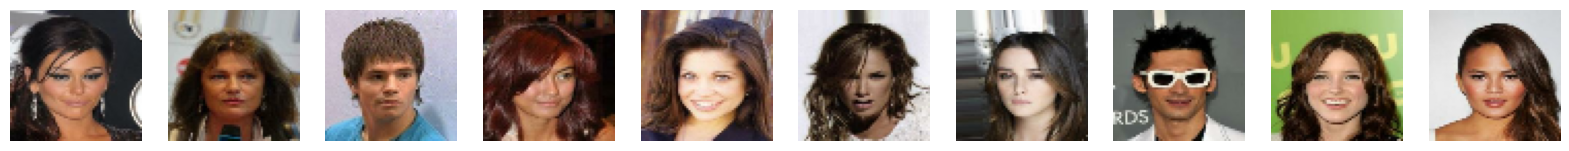

Reconstructions


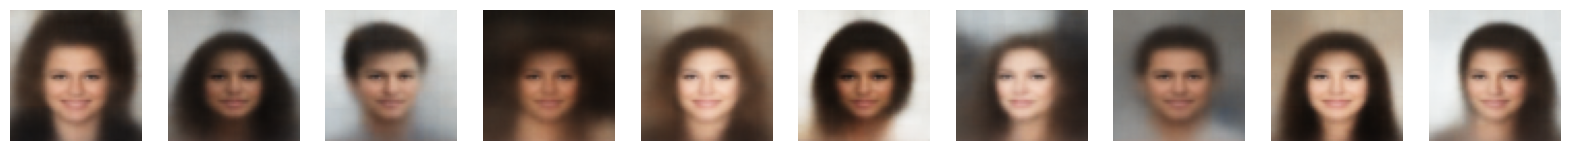

In [21]:
# Créer des prédictions de l'autoencodeur et les afficher
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Afficher les vrais visages de l'exemple
print("Exemples de vrais visages")
display(example_images)

# Afficher les reconstructions
print("Reconstructions")
display(reconstructions)

# Distribution de l'espace latent

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


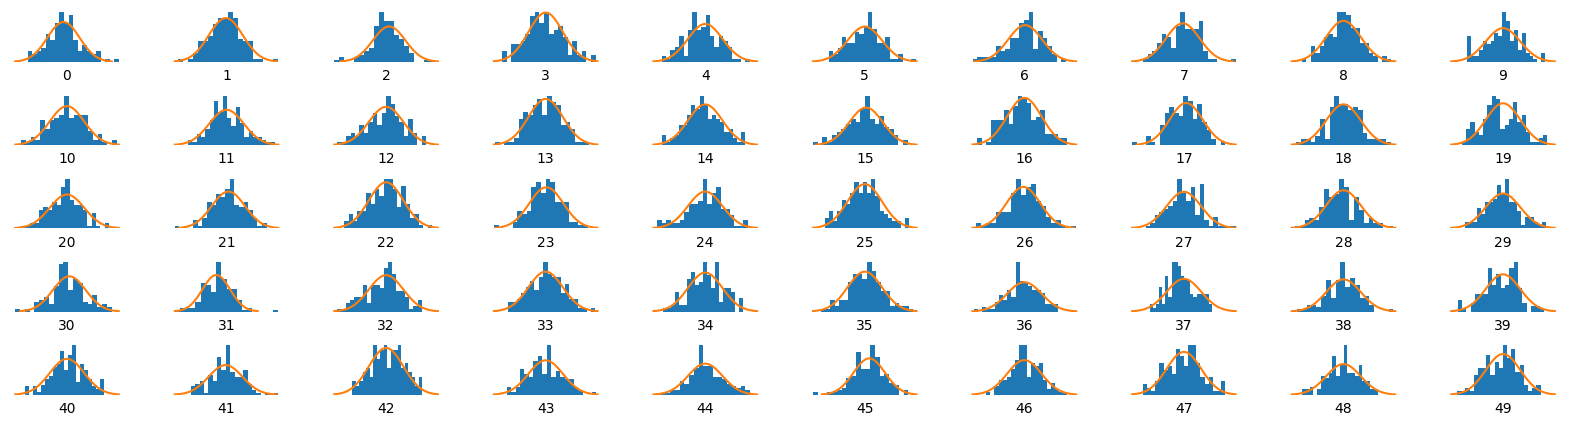

In [22]:
_, _, z = vae.encoder.predict(example_images)  # Obtenir les vecteurs de l'espace latent pour les images d'exemple

x = np.linspace(-3, 3, 100)  # Créer une séquence de valeurs pour la distribution

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)  # Afficher un histogramme des valeurs de l'espace latent
    ax.axis("off")  # Désactiver les axes
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )  # Ajouter une étiquette pour l'index de la dimension latente
    ax.plot(x, norm.pdf(x))  # Tracer la distribution de probabilité attendue (normale)

plt.show()  # Afficher la figure

# Générer de nouveaux visages

In [23]:
# Échantillonner des points dans l'espace latent à partir de la distribution normale standard
grid_width, grid_height = (10, 3)  # Dimensions de la grille d'échantillonnage
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))  # Générer des échantillons aléatoires dans l'espace latent

In [24]:
# Décoder les points échantillonnés
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


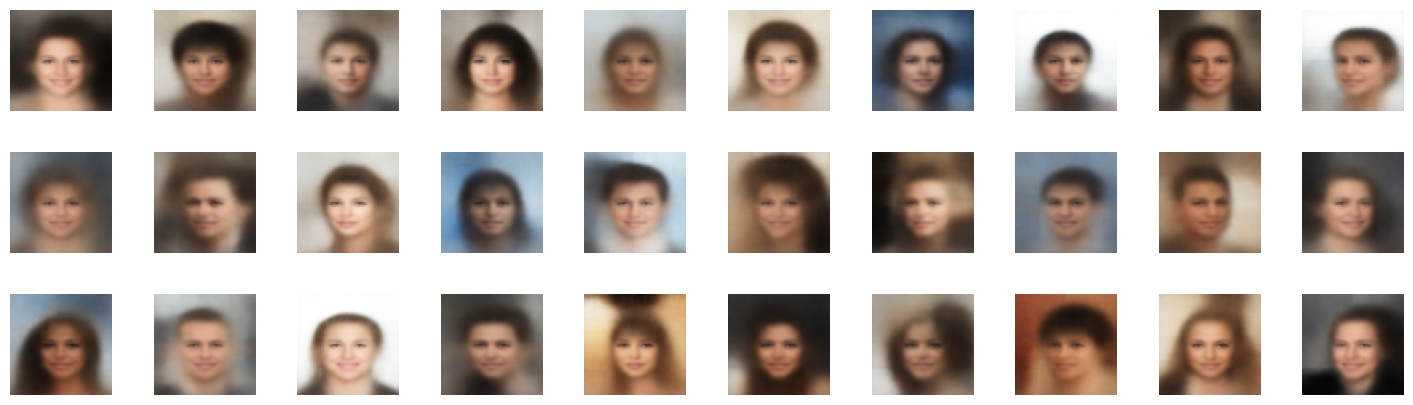

In [25]:
# Créer un graphique des images décodées
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Afficher la grille des visages générés
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")  # Désactiver les axes
    ax.imshow(reconstructions[i, :, :])  # Afficher l'image décodée

# Modifier des images

In [26]:
# Charger l'ensemble de données d'étiquettes
attributes = pd.read_csv(data_dir + "/list_attr_celeba.csv")
print(attributes.columns)  # Afficher les noms des colonnes de l'ensemble de données
attributes.head()  # Afficher les premières lignes de l'ensemble de données

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [27]:
# Charger les données de visages avec les étiquettes associées
LABEL = "Smiling"  # <- Définissez cette étiquette
labelled_test = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

# Prétraiter les données d'images et d'étiquettes
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [28]:
# Trouver le vecteur d'attribut
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Smiling
images : POS move : NEG move :distance : 𝛥 distance
59    : 1.792    : 1.817    : 2.472    : 2.472
120    : 1.287    : 1.229    : 1.795    : -0.677
182    : 0.774    : 0.696    : 1.457    : -0.338
236    : 0.47    : 0.485    : 1.266    : -0.191
299    : 0.39    : 0.346    : 1.206    : -0.06
364    : 0.336    : 0.285    : 1.158    : -0.047
424    : 0.291    : 0.283    : 1.08    : -0.078
490    : 0.256    : 0.221    : 1.017    : -0.063
547    : 0.198    : 0.215    : 0.942    : -0.076
605    : 0.186    : 0.176    : 0.905    : -0.036
664    : 0.175    : 0.166    : 0.856    : -0.049
721    : 0.144    : 0.167    : 0.835    : -0.021
776    : 0.137    : 0.133    : 0.837    : 0.002
834    : 0.127    : 0.128    : 0.813    : -0.024
890    : 0.121    : 0.108    : 0.788    : -0.026
957    : 0.13    : 0.105    : 0.785    : -0.003
1025    : 0.11    : 0.1    : 0.776    : -0.009
1092    : 0.105    : 0.089    : 0.782    : 0.006
1155    : 0.09    : 0.098    : 0.786    : 0.004
1202    : 0.0

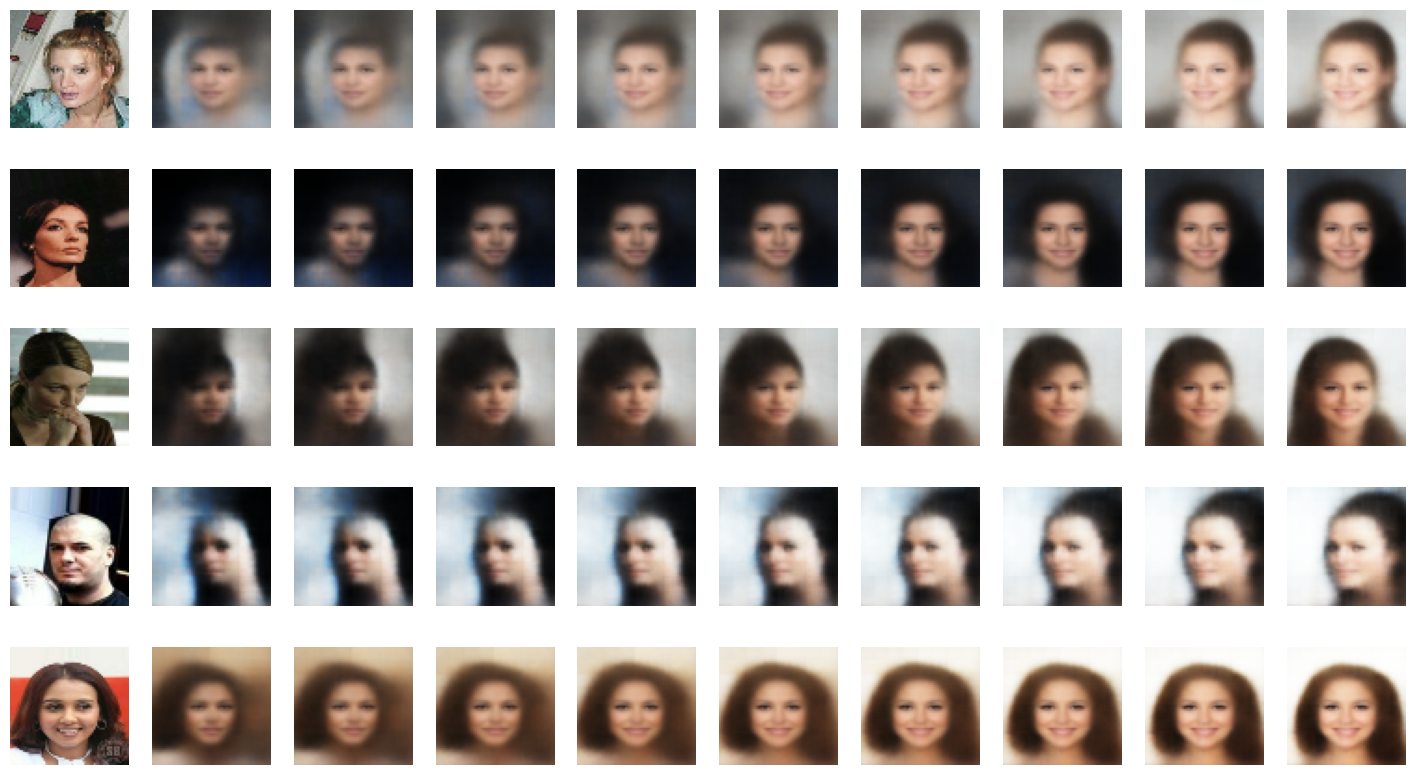

In [29]:
# Ajouter le vecteur aux images
add_vector_to_images(labelled, vae, attribute_vec)

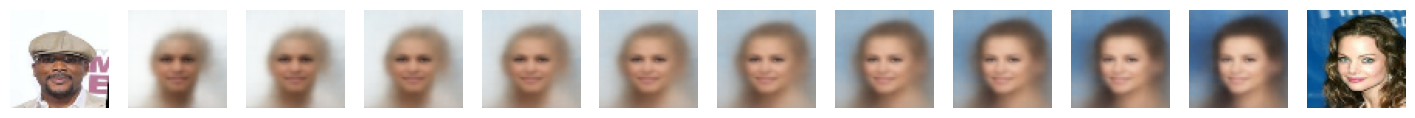

In [30]:
# Créer une interpolation entre deux images en fonction de facteurs
morph_faces(labelled, vae)

In [31]:
# Charger les données de visages avec les étiquettes associées
LABEL = "Blond_Hair"  # <- Définissez cette étiquette
labelled_test = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

# Prétraiter les données d'images et d'étiquettes
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [32]:
# Trouver le vecteur d'attribut
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.026    : 1.414    : 3.42    : 3.42
44    : 2.06    : 0.879    : 2.664    : -0.756
65    : 1.259    : 0.527    : 2.244    : -0.42
87    : 0.805    : 0.394    : 2.147    : -0.097
110    : 0.701    : 0.294    : 1.976    : -0.172
128    : 0.452    : 0.252    : 1.905    : -0.071
150    : 0.49    : 0.222    : 1.868    : -0.036
171    : 0.38    : 0.182    : 1.818    : -0.051
197    : 0.384    : 0.151    : 1.781    : -0.036
218    : 0.305    : 0.136    : 1.745    : -0.037
241    : 0.267    : 0.128    : 1.697    : -0.048
260    : 0.244    : 0.127    : 1.67    : -0.027
282    : 0.242    : 0.106    : 1.646    : -0.024
302    : 0.211    : 0.103    : 1.606    : -0.04
317    : 0.163    : 0.093    : 1.604    : -0.002
337    : 0.198    : 0.081    : 1.586    : -0.018
356    : 0.169    : 0.089    : 1.562    : -0.024
377    : 0.179    : 0.071    : 1.554    : -0.008
395    : 0.156    : 0.072    : 1.548    : -0.006
415    : 0.1

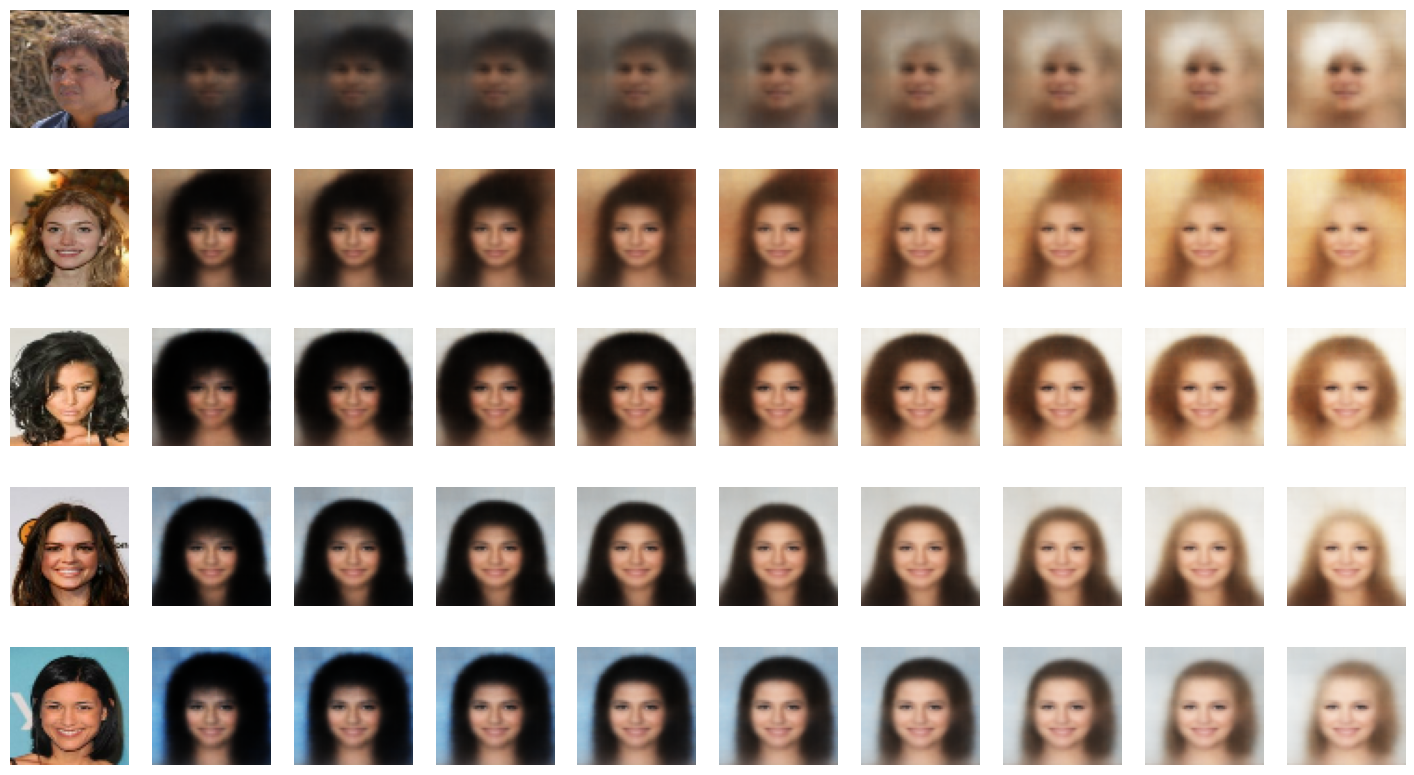

In [33]:
# Ajouter le vecteur aux images
add_vector_to_images(labelled, vae, attribute_vec)

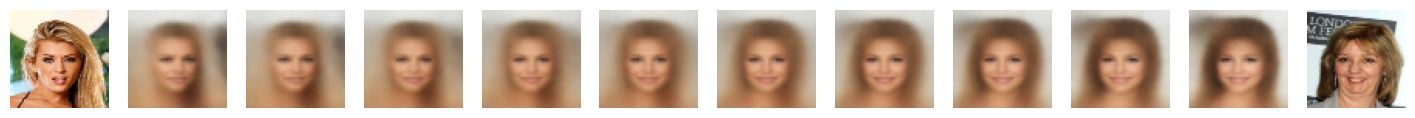

In [34]:
# Créer une interpolation entre deux images en fonction de facteurs
morph_faces(labelled, vae)